## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [174]:
import os
import json

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Загрузка данных происходит ниже. Если она не срабатывает, самостоятельно скачайте файл `hw_final_open_data.npy` и положите его в ту же директорию, что и ноутбук.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_target.npy

In [840]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

### Hint 2: Анализируем фичи

In [644]:
data.shape

(800, 7)

In [645]:
import pandas as pd
df = pd.DataFrame(data)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,0,1,2,3,4,5,6
0,1.000,0.938,0.290,0.966,0.995,0.944,0.300
1,0.938,1.000,0.169,0.996,0.969,1.000,0.175
2,0.290,0.169,1.000,0.197,0.251,0.174,0.999
3,0.966,0.996,0.197,1.000,0.988,0.997,0.204
4,0.995,0.969,0.251,0.988,1.000,0.973,0.260
5,0.944,1.000,0.174,0.997,0.973,1.000,0.180
6,0.300,0.175,0.999,0.204,0.260,0.180,1.000


**1. Filter methods**: 1. Basic methods. 1. Remove constant features using variance threshold

In [646]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(data)

VarianceThreshold(threshold=0)

In [647]:
non_const_feat_num = sum(sel.get_support())
print("Non-constant features number: ", non_const_feat_num)

Non-constant features number:  7


**1. Filter methods**: 1. Basic methods. 2. Remove quasi-constant features using variance threshold

In [648]:
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(data)

VarianceThreshold(threshold=0.01)

In [649]:
quasi_const_feat_num = sum(sel.get_support())
print("Non-constant features number: ", quasi_const_feat_num)

Non-constant features number:  3


In [650]:
quasi_const_indices = np.where(~sel.get_support())[0]
print("Quasi-const feature indices: ", quasi_const_indices)

Quasi-const feature indices:  [0 2 4 6]


In [651]:
def get_table_sizes(arr_len):
    arr_len_sqrt = np.sqrt(arr_len)
    sup_sqrt = int(np.ceil(arr_len_sqrt))
    inf_sqrt = int(np.floor(arr_len_sqrt))

    inf_dist = arr_len - inf_sqrt ** 2
    sup_dist = sup_sqrt ** 2 - arr_len

    if inf_dist < sup_dist:
        return inf_sqrt + 1, inf_sqrt
    else:
        return sup_sqrt, sup_sqrt

In [652]:
def draw_distributions(data, indices=None, plot_type='violin'):
    """Draw disitributions

    Args:
        data (np.ndarray): data matrix
        indices (list, optional): List of indices to analyze. Defaults to None.
        plot_type (str, optional): plot type: 'box', 'hist' or 'violin'. Defaults to 'violin'.
    """
    
    if indices is None:
        indices = list(range(data.shape[1]))

    rows, cols = get_table_sizes(len(indices))
    fig, axs = plt.subplots(rows, cols)

    # plot_type = 'violin' # 'box', 'hist', 'violin'

    for i, ind in enumerate(indices):
        plot_data = data[:, ind]
        if plot_type == 'hist':
            axs[i // cols, i % cols].hist(plot_data, color='lightgreen', ec='black', bins=10)
        elif plot_type == 'box':
            axs[i // cols, i % cols].boxplot(plot_data)
        elif plot_type == 'violin':
            axs[i // cols, i % cols].violinplot(plot_data, showmeans=False, showmedians=True)
        axs[i // cols, i % cols].set_title(f'Feature {ind}')
    fig.tight_layout()

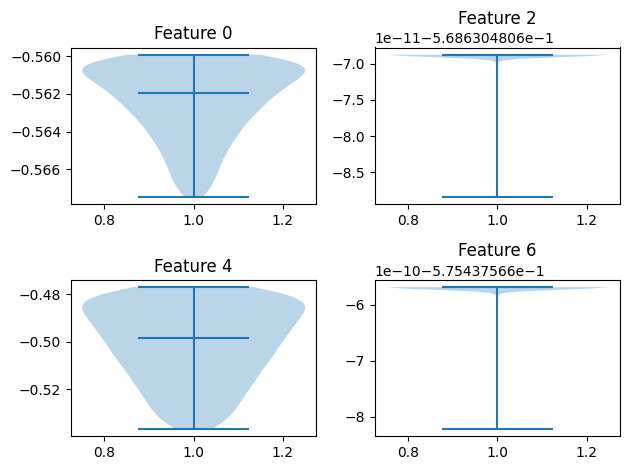

In [653]:
draw_distributions(data, indices=quasi_const_indices)

Вывод: фичи 0, 2, 4, 6 - неинформативны, их удаляем

In [654]:
# reduced_data = np.take(data, [0,1,3,4,5], axis=1)
reduced_data = np.take(data, [1,3,5], axis=1)
# reduced_data = data
reduced_data.shape

(800, 3)

**1. Filter methods**: Correlation matrix

In [655]:
import pandas as pd
df = pd.DataFrame(reduced_data)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,0,1,2
0,1.000,0.996,1.000
1,0.996,1.000,0.997
2,1.000,0.997,1.000


In [656]:
#np.corrcoef(data.T)

### Hint 3. Нормализация данных

In [657]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(reduced_data)

StandardScaler()

In [658]:
transformed_data = scaler.transform(reduced_data)

In [659]:
transformed_data[:, 0].min()

-1.4868329213279752

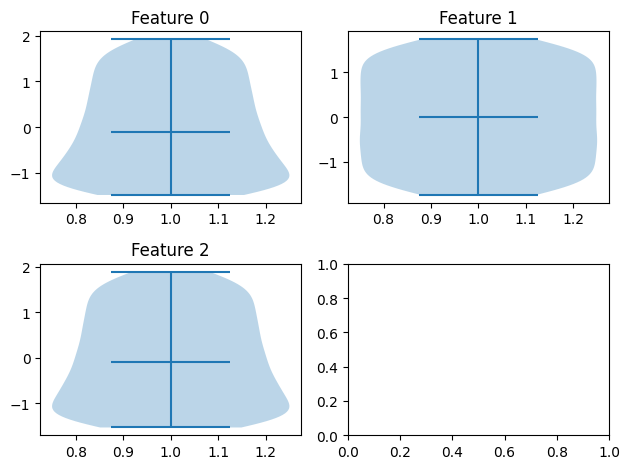

In [660]:
draw_distributions(transformed_data)

Разбивка на `train` и `val` опциональна и сделана для вашего удобства.

In [661]:
train_x, valid_x, train_y, valid_y = train_test_split(transformed_data, target, test_size=0.3)

### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

Пример с использованием Random Forest доступен ниже.

In [662]:
def calc_mse(x_data, y_data, model):
    return mean_squared_error(np.round(model.predict(x_data), 2), np.round(y_data))

def calc_score(mse):
    return max(np.round((1 - mse) * 1.5, 2), 0)

In [668]:
rng = np.random.RandomState(0)  # Hint 1: Фиксируем random_state для контроля случайности
rf = RandomForestRegressor(
    random_state=rng,
    n_estimators=10,
    max_depth=4,
    min_samples_leaf=3,
    # max_features=1
    )
rf.fit(train_x, train_y)

print(
    f'train mse =\t {calc_mse(train_x, train_y, rf):.5f}',
    f'validation mse = {calc_mse(valid_x, valid_y, rf):.5f}',
    f'score on validation = {calc_score(calc_mse(valid_x, valid_y, rf)):.5f}',
    sep='\n'
)

train mse =	 0.16189
validation mse = 0.21302
score on validation = 1.18000


In [669]:
from sklearn.ensemble import GradientBoostingRegressor

rng = np.random.RandomState(0)  # Hint 1: Фиксируем random_state для контроля случайности
gb_ens = GradientBoostingRegressor(
    random_state=rng, 
    n_estimators=100,
    max_depth=3,
    learning_rate=0.06,
    # validation_fraction=0.2,
    # n_iter_no_change=5,
    )
gb_ens.fit(train_x, train_y)

print(
    f'train mse =\t {calc_mse(train_x, train_y, gb_ens):.5f}',
    f'validation mse = {calc_mse(valid_x, valid_y, gb_ens):.5f}',
    f'score on validation = {calc_score(calc_mse(valid_x, valid_y, gb_ens)):.5f}',
    sep='\n'
)

train mse =	 0.14139
validation mse = 0.21041
score on validation = 1.18000


In [672]:
rng = np.random.RandomState(0)  # Hint 1: Фиксируем random_state для контроля случайности
lr_1 = Ridge(random_state=rng)
lr_1.fit(train_x, train_y)
print(
    f'train mse =\t {calc_mse(train_x, train_y, lr_1):.5f}',
    f'validation mse = {calc_mse(valid_x, valid_y, lr_1):.5f}',
    f'score on validation = {calc_score(calc_mse(valid_x, valid_y, lr_1)):.5f}',
    sep='\n'
)

train mse =	 0.17248
validation mse = 0.20444
score on validation = 1.19000


In [673]:
from sklearn.linear_model import SGDRegressor

rng = np.random.RandomState(0)  # Hint 1: Фиксируем random_state для контроля случайности
sgd_reg = SGDRegressor(penalty="l2", random_state=rng, max_iter=1000, tol=1e-3)
sgd_reg.fit(train_x, train_y)

print(
    f'train mse =\t {calc_mse(train_x, train_y, sgd_reg):.5f}',
    f'validation mse = {calc_mse(valid_x, valid_y, sgd_reg):.5f}',
    f'score on validation = {calc_score(calc_mse(valid_x, valid_y, sgd_reg)):.5f}',
    sep='\n'
)

train mse =	 0.17243
validation mse = 0.20463
score on validation = 1.19000


##### Нейронная сеть

In [723]:
import torch
from torch import nn

In [722]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [791]:
class FinalTaskModel(nn.Module):
    def __init__(self, in_size) -> None:
        super(FinalTaskModel, self).__init__()
        self.linear1 = nn.Linear(in_size, 50)
        self.linear2 = nn.Linear(50, 25)
        self.linear3 = nn.Linear(25, 1)
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.double()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.softmax(x)
        return x

In [792]:
model = FinalTaskModel(train_x.shape[1]) # your code here

In [793]:
print('The model:')
print(model)

# print('\n\nModel params:')
# for param in model.parameters():
#     print(param)

The model:
FinalTaskModel(
  (linear1): Linear(in_features=3, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=25, bias=True)
  (linear3): Linear(in_features=25, out_features=1, bias=True)
  (activation): ReLU()
  (softmax): Softmax(dim=1)
)


In [794]:
from torch.utils.data import Dataset, DataLoader

In [795]:
class FinalTaskDataset(Dataset):
    """Final Task dataset."""

    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return {'features': self.x_data[idx, :].astype('float'), 'label': self.y_data[idx].astype('float')}

In [796]:
my_dataset = FinalTaskDataset(train_x, train_y)

In [797]:
train_dataloader = DataLoader(my_dataset, batch_size=4, shuffle=True, num_workers=4)

In [798]:
random_batch = next(iter(train_dataloader))

In [799]:
random_batch['label']

tensor([2.1638, 5.4580, 3.3772, 0.6753], dtype=torch.float64)

In [800]:
loss_fn = nn.MSELoss()

In [801]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [802]:
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data['features'], data['label']

        # inputs = inputs.view(32, -1)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [803]:
EPOCHS = 20
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch()


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    print('LOSS train {}'.format(avg_loss))

EPOCH 1:
LOSS train 0.0
EPOCH 2:
LOSS train 0.0
EPOCH 3:
LOSS train 0.0
EPOCH 4:
LOSS train 0.0
EPOCH 5:
LOSS train 0.0
EPOCH 6:
LOSS train 0.0
EPOCH 7:
LOSS train 0.0
EPOCH 8:
LOSS train 0.0
EPOCH 9:
LOSS train 0.0
EPOCH 10:
LOSS train 0.0
EPOCH 11:
LOSS train 0.0
EPOCH 12:
LOSS train 0.0
EPOCH 13:
LOSS train 0.0
EPOCH 14:
LOSS train 0.0
EPOCH 15:
LOSS train 0.0
EPOCH 16:
LOSS train 0.0
EPOCH 17:
LOSS train 0.0
EPOCH 18:
LOSS train 0.0
EPOCH 19:
LOSS train 0.0
EPOCH 20:
LOSS train 0.0


In [809]:
model.eval()

FinalTaskModel(
  (linear1): Linear(in_features=3, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=25, bias=True)
  (linear3): Linear(in_features=25, out_features=1, bias=True)
  (activation): ReLU()
  (softmax): Softmax(dim=1)
)

In [819]:
np.array(model(torch.tensor(valid_x)).detach())

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

--2023-11-29 07:40:34--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [application/octet-stream]
Saving to: ‘hw_final_closed_data.npy’

hw_final_closed_dat 100%[===================>]  11.06K  --.-KB/s    in 0s      

2023-11-29 07:40:34 (65.9 MB/s) - ‘hw_final_closed_data.npy’ saved [11328/11328]



In [674]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [675]:
# optional transformations
# closed_data = np.take(closed_data, [0,1,3,4,5], axis=1)
closed_data = np.take(closed_data, [1,3,5], axis=1)
closed_data = scaler.transform(closed_data)
closed_data.shape

(200, 3)

In [676]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [679]:
predicted_values = np.round(get_predictions(model=sgd_reg, eval_data=closed_data), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

In [678]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)

print('File saved to `submission_dict_final_p01.npy`')
# __________end of block__________

File saved to `submission_dict_final_p01.npy`






### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [864]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

In [869]:
def my_transformation(feature_matrix: np.ndarray):
    # new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    # new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    # new_feature_matrix[:, -1] = feature_matrix[:, 0] * feature_matrix[:, 1]

    # new_feature_matrix = feature_matrix
    new_feature_matrix = np.take(feature_matrix, [1,3,5], axis=1)
    
    print(f"Shapes before: {feature_matrix.shape}, after: {new_feature_matrix.shape}")
    return new_feature_matrix

In [870]:
transformed_train_x = my_transformation(train_x)

Shapes before: (560, 7), after: (560, 3)


In [871]:
rng = np.random.RandomState(0)
lr = Ridge(random_state=rng)
lr.fit(transformed_train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(lr.predict(transformed_train_x), train_y):.5f}',
    f'validation mse = {mean_squared_error(lr.predict(my_transformation(valid_x)), valid_y):.5f}',
    f'score on validation = {calc_score(calc_mse(my_transformation(valid_x), valid_y, lr)):.5f}',
    sep='\n'
)

Shapes before: (240, 7), after: (240, 3)
Shapes before: (240, 7), after: (240, 3)
train mse =	 0.09344
validation mse = 0.08412
score on validation = 1.23000


Обращаем ваше внимание, что параметры линейной модели будут округляться до __четырех знаков после запятой__. Это не должно сильно повлиять на качество предсказаний:

In [872]:
original_predictions = lr.predict(transformed_train_x)
rounded_predictions = transformed_train_x.dot(np.round(lr.coef_, 4)) + np.round(lr.intercept_, 4)


assert np.allclose(original_predictions, rounded_predictions, atol=1e-3)

Параметры вашей модели:

In [873]:
w_list = list(np.round(lr.coef_, 4))
print(f'w = {list(np.round(lr.coef_, 4))}\nb = {np.round(lr.intercept_, 4)}')

w = [0.4587, 0.6328, 1.4441]
b = 1.3811


Напоминаем, ваша модель не должна использовать более 15 параметров (14 весов плюс свободный член).

In [874]:
assert len(w_list) + 1 <= 15

##### Сдача второй части соревнования
Для сдачи вам достаточно отправить функцию `my_transformation` и параметры вашей модели в контест в задачу №2. Пример посылки доступен ниже

In [875]:
# __________example_submission_start__________

def my_transformation(feature_matrix: np.ndarray):
    new_feature_matrix = np.zeros((feature_matrix.shape[0], feature_matrix.shape[1]+1))
    new_feature_matrix[:, :feature_matrix.shape[1]] = feature_matrix
    new_feature_matrix[:, -1] = feature_matrix[:, 0
    ] * feature_matrix[:, 1]
    return new_feature_matrix

w_submission = [-0.0027, -0.2637, 0.0, -0.1134, -0.0165, -0.9329, 0.0, 0.1293]
b_submission = 1.1312
# __________example_submission_end__________

На этом задание завершено. Поздравляем!

### Идеи, заметки, hint-ы

1. random_state - https://scikit-learn.ru/10-3-controlling-randomness/  
2. Графики для анализа фичей (вид зависимости таргета от фичей и их комбинаций) + корреляции признаков друг с другом - https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection  
3. Нормализация/стандартизация данных - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html без дата ликов + посмотреть на аномалии в таргете и фичах  
4. XGBoost - https://xgboost.readthedocs.io/en/stable/ + shap values - https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
для важности признаков и предпосылок  
5. Подумайте над методами оптимизации гиперпараметров помимо GridSearchCV  
6. Подумать на stacking-ом в пункте 1 (какие модельки взят?)  
7. Как отбирать топ фичей после генерации новых? точно не Brute-force - https://dataaspirant.com/stepwise-regression/